### Importing Libs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)


2023-05-19 13:31:16.806372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 13:31:16.982737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 13:31:16.986974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 13:31:19.415342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading Data

In [4]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

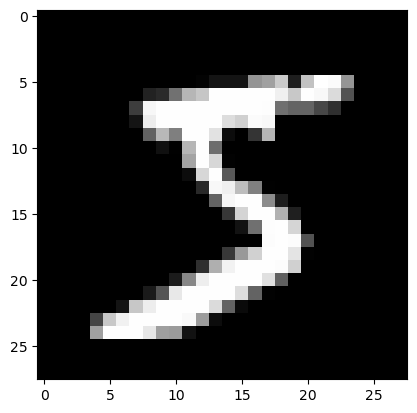

In [5]:
plt.imshow(mnist_digits[0], cmap="Greys_r")

### Encoder

In [7]:
def build_encoder(
    input_shape,
    latent_dim,
    filters_1=32,
    filters_2=64,
    kernel_size_1=3,
    kernel_size_2=3,
    strides_1=2,
    strides_2=2,
):
    encoder = tf.keras.Sequential(
        [
            keras.Input(shape=input_shape, name="image_input"),
            layers.Conv2D(
                filters=filters_1,
                kernel_size=kernel_size_1,
                activation="relu",
                strides=strides_1,
                padding="same",
                name="encoder_convolution_1",
            ),
            layers.Conv2D(
                filters=filters_2,
                kernel_size=kernel_size_2,
                activation="relu",
                strides=strides_2,
                padding="same",
                name="encoder_convolution_2",
            ),
            layers.Flatten(name="encoder_flatten"),
            layers.Dense(latent_dim, name="encoder_output"),
        ],
        name="encoder",
    )
    return encoder

In [8]:
LATENT_DIM = 2 
INPUT_SHAPE = (28, 28, 1) 

encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_convolution_1 (Conv  (None, 14, 14, 32)       320       
 2D)                                                             
                                                                 
 encoder_convolution_2 (Conv  (None, 7, 7, 64)         18496     
 2D)                                                             
                                                                 
 encoder_flatten (Flatten)   (None, 3136)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 6274      
                                                                 
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [10]:
def build_decoder(latent_dim, encoder):
    decoder = tf.keras.Sequential(
        [
            keras.Input(shape=latent_dim, name="decoder_input"),
            layers.Dense(
                encoder.layers[-1].input.shape[1],
                activation="relu",
                name="decoder_dense",
            ),
            layers.Reshape(
                encoder.layers[-2].input.shape[1:],
                name="decoder_reshape",
            ),
            layers.Conv2DTranspose(
                filters=encoder.layers[-3].input.shape[-1], 
                kernel_size=encoder.layers[-3].kernel_size, 
                activation="relu",
                strides=encoder.layers[-3].strides,  
                padding="same",
                name="decoder_deconvolution_1",
            ),
            layers.Conv2DTranspose(
                filters=encoder.layers[-4].input.shape[-1],
                kernel_size=encoder.layers[-4].kernel_size, 
                activation="sigmoid",
                strides=encoder.layers[-4].strides,
                padding="same",
                name="decoder_deconvolution_2",
            ),
        ],
        name="decoder",
    )
    return decoder

In [11]:
decoder = build_decoder(LATENT_DIM, encoder)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_dense (Dense)       (None, 3136)              9408      
                                                                 
 decoder_reshape (Reshape)   (None, 7, 7, 64)          0         
                                                                 
 decoder_deconvolution_1 (Co  (None, 14, 14, 32)       18464     
 nv2DTranspose)                                                  
                                                                 
 decoder_deconvolution_2 (Co  (None, 28, 28, 1)        289       
 nv2DTranspose)                                                  
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


### Build autoencoder

In [13]:
def build_autoencoder(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim, encoder)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.build(input_shape=(None, *input_shape))
    return encoder, decoder, autoencoder

In [14]:
encoder, decoder, autoencoder = build_autoencoder(INPUT_SHAPE, LATENT_DIM)

autoencoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 2)                 25090     
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

In [ ]:
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

### Visualise the latent space

In [16]:
def plot_label_clusters(encoder, data, labels):
    z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train)

### Visualise decoder

In [19]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    samples = [[x, y] for y in grid_y for x in grid_x]
    x_decoded = decoder.predict(samples)
    figure = np.zeros((digit_size * n, digit_size * n))
    for i in range(n):
        for j in range(n):
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = x_decoded[i * n + j].reshape(digit_size, digit_size)

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


29/29 [==============================] - 1s 5ms/step


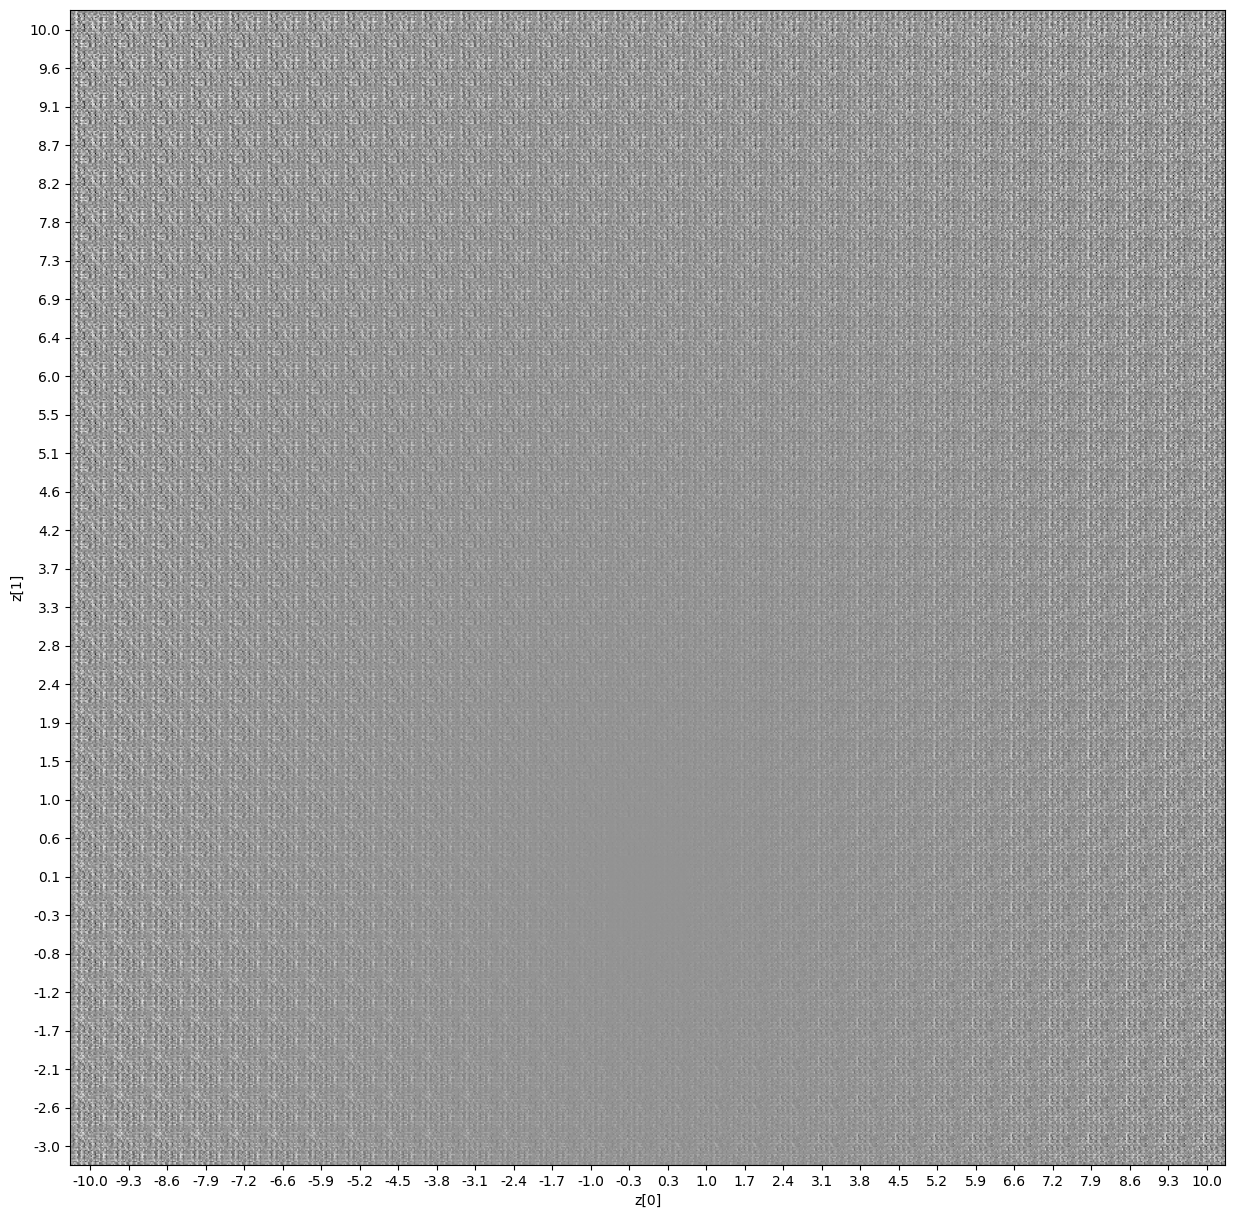

In [20]:
plot_latent_space(decoder, n=30, ranges=[-10, 10, -3, 10], figsize=15)

### AutoEncoder for Anomaly Detection

In [ ]:
encoder, decoder, autoencoder = build_autoencoder(INPUT_SHAPE, latent_dim=32)

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

In [ ]:
num_sample = 2000 

reconstructions = autoencoder.predict(x_train[:num_sample])
train_loss = tf.reduce_mean(
    tf.keras.losses.mae(reconstructions, x_train[:num_sample]), axis=(1, 2)
)

In [ ]:
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
sigma = 2

threshold = np.mean(train_loss) + np.std(train_loss) * sigma
print("Threshold: ", threshold)

In [ ]:
fig = plt.figure()
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.vlines(threshold, 0, 160, color="red")
plt.show()

### Prediction

In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(
        tf.keras.losses.mae(reconstructions, data), axis=(1, 2)
    )
    return tf.math.greater(loss, threshold), loss[0], reconstructions

In [ ]:
def plot_reconstruction(model, data, threshold):
    is_anomaly, loss, reconstruction = predict(
        model, tf.expand_dims(data, 0), threshold
    )

    f, axarr = plt.subplots(1, 2)
    lossMSG = f"loss:{loss:.4f}"
    thMSG = f"threshold:{threshold:.4f}"
    text_anomaly = (
        f"Anomaly ({lossMSG} > {thMSG})"
        if is_anomaly
        else f"Normal ({lossMSG} <= {thMSG})"
    )
    title = f.suptitle(text_anomaly)
    c = "r" if is_anomaly else "g"
    plt.setp(title, color=c)

    axarr[0].imshow(data, cmap="Greys_r")
    axarr[0].set_title("Original Image")
    axarr[1].imshow(reconstruction[0], cmap="Greys_r")
    axarr[1].set_title("Reconstructed Image")
    f.show()

### Normal Data

In [ ]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, d, threshold)

### Anomaly Data

In [ ]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, np.rot90(d), threshold)

### Negatively inversed images

In [ ]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, 1 - d, threshold)

### Images with whitenoise

In [ ]:
def add_noise_and_scale(d):
    noise = np.random.normal(0, 0.05, size=(28, 28, 1))
    _d = d + noise
    return _d - np.min(_d) / (np.max(_d) - np.min(_d))


for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, add_noise_and_scale(d), threshold)